In [7]:
# Install required libraries
!pip install pmdarima

#dataset: https://www.kaggle.com/datasets/bbjadeja/walmart-demand-and-forecasting-solution

import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Load your data (replace 'your_data.csv' with the actual file path)
data = pd.read_csv('Walmart.csv')

data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y', errors='coerce')

# Check for any parsing issues
if data['Date'].isnull().any():
    print("Warning: Some dates could not be parsed. Check your data for inconsistencies.")

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

# Print the available columns in your DataFrame
print(data.columns)



Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment'],
      dtype='object')


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=6.15 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=629.777, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=631.943, Time=0.82 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=631.081, Time=0.33 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=631.333, Time=0.04 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=631.183, Time=0.10 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=631.175, Time=0.22 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=630.529, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=631.314, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=632.711, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 8.236 seconds


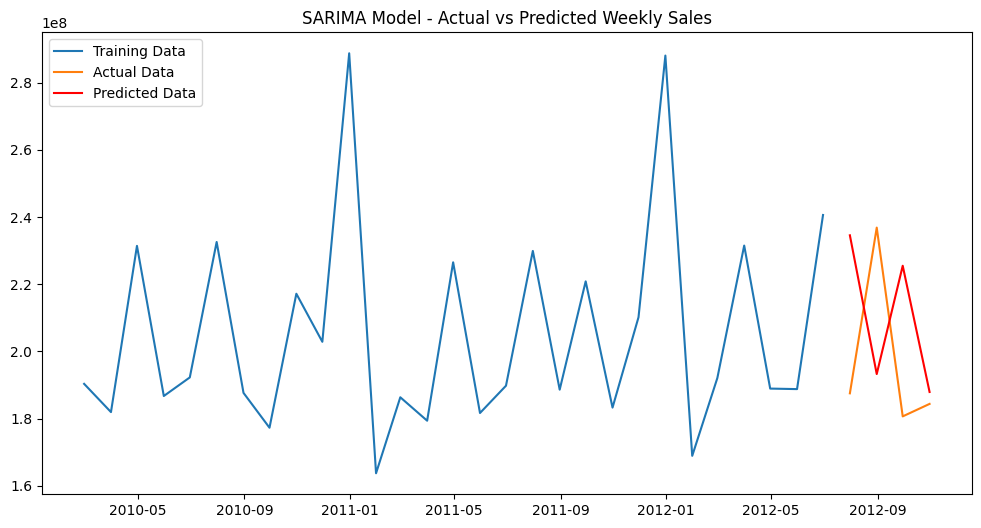

Root Mean Squared Error: 39176528.16


In [10]:
# Aggregate weekly sales data to month-end (using 'ME' for month-end frequency)
monthly_sales = data['Weekly_Sales'].resample('ME').sum()

# Check if the data is non-empty after resampling
if monthly_sales.empty:
    print("Error: The resampled data is empty. Please check the original data and date parsing.")
else:
    # Train-test split
    # Increased train_size to 0.9 to provide more data for training
    train_size = int(len(monthly_sales) * 0.9)
    train, test = monthly_sales[:train_size], monthly_sales[train_size:]

    # Ensure training data is non-empty and has sufficient length
    if len(train) == 0 or len(test) == 0:
        print("Error: The training or testing dataset is empty or too small. Please verify the data split.")
    else:
        # Fit the SARIMA model
        model = auto_arima(train, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True,
                           # Added D=1 to specify the seasonal differencing order
                           D=1
                          )
        model.fit(train)

        # Make predictions
        forecast = model.predict(n_periods=len(test))
        test.index = pd.date_range(start=test.index[0], periods=len(test), freq='ME')

        # Plot actual vs. predicted values
        plt.figure(figsize=(12, 6))
        plt.plot(train.index, train, label='Training Data')
        plt.plot(test.index, test, label='Actual Data')
        plt.plot(test.index, forecast, label='Predicted Data', color='red')
        plt.legend(loc='upper left')
        plt.title('SARIMA Model - Actual vs Predicted Weekly Sales')
        plt.show()

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(test, forecast))
        print(f'Root Mean Squared Error: {rmse:.2f}')